NOAA dataset. Eight  features. Two classes.
50 batches of 345 instances



METHOD: Static lp as classifier
Execution time:  0.44551737908414
Average MCC:  0.16501230519640905
Average error: 28.522599999999997
Average macro-F1: 0.5052154807402618
Average micro-F1: 0.69
Acurácia Média:  71.4774
Desvio Padrão:  3.78671668335512
Variância:  14.339223239999999


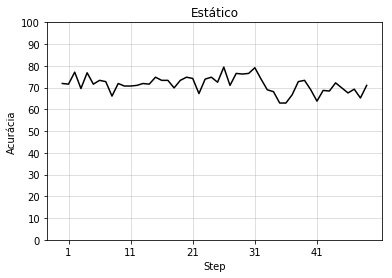

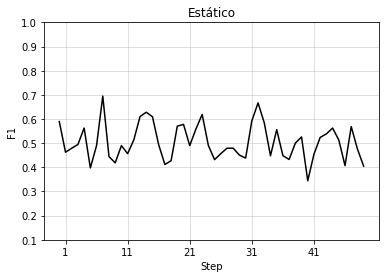




METHOD: Sliding lp as classifier
Execution time:  0.30576377184767833
Average MCC:  0.007404470266421323
Average error: 31.297799999999995
Average macro-F1: 0.39883294066284464
Average micro-F1: 0.6576
Acurácia Média:  68.7022
Desvio Padrão:  4.599381823680222
Variância:  21.154313160000005


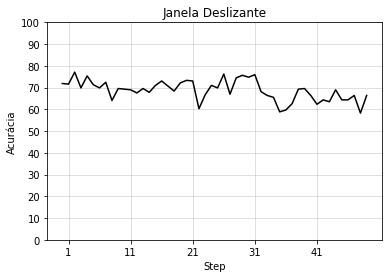

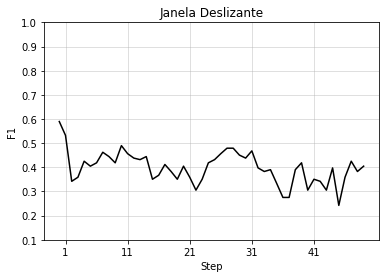




METHOD: Incremental lp as classifier
Execution time:  11.158987121777841
Average MCC:  0.030538620880854284
Average error: 30.95599999999999
Average macro-F1: 0.4147459050049113
Average micro-F1: 0.6628000000000001
Acurácia Média:  69.04400000000001
Desvio Padrão:  4.9634770070989545
Variância:  24.636103999999996


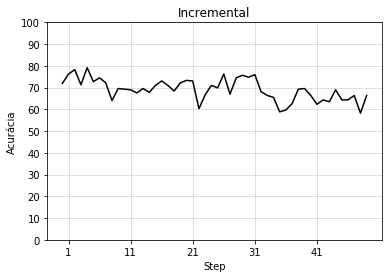

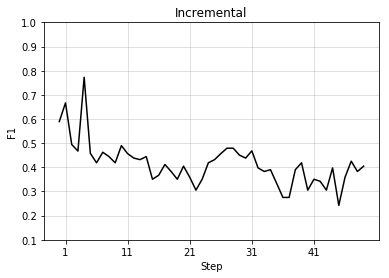




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.6380979157912865
Average MCC:  0.07009963493645543
Average error: 41.363
Average macro-F1: 0.4518915542743332
Average micro-F1: 0.5940000000000001
Acurácia Média:  58.637
Desvio Padrão:  4.743952044445643
Variância:  22.505080999999993


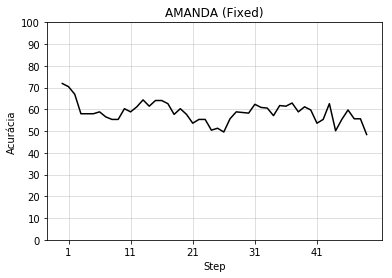

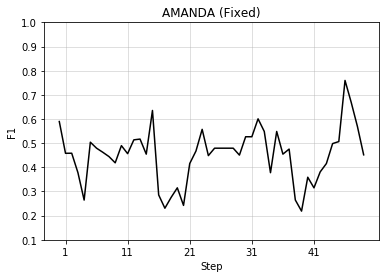




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.44 | Std keeping percentage=0.12
Execution time:  0.6444684479358376
Average MCC:  0.002857142857142857
Average error: 31.390399999999985
Average macro-F1: 0.39157893915596953
Average micro-F1: 0.6555999999999998
Acurácia Média:  68.60960000000001
Desvio Padrão:  4.57151132996518
Variância:  20.898715840000005


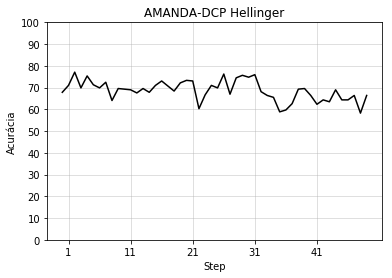

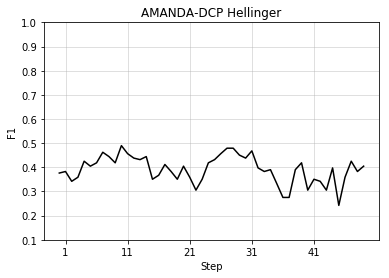




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.25 | Std keeping percentage=0.04
Execution time:  0.6082155387738464
Average MCC:  0.002857142857142857
Average error: 31.401999999999987
Average macro-F1: 0.39157893915596953
Average micro-F1: 0.6555999999999998
Acurácia Média:  68.59800000000001
Desvio Padrão:  4.574209877126322
Variância:  20.923396000000007


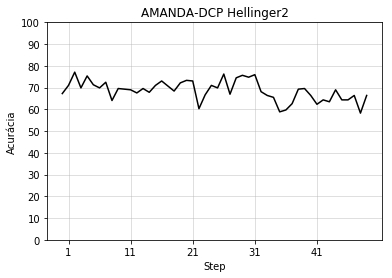

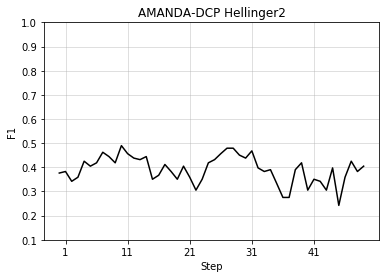




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.11 | Std keeping percentage=0.02
Execution time:  0.6079160307693918
Average MCC:  0.03220299527937106
Average error: 41.68200000000001
Average macro-F1: 0.4212022474923198
Average micro-F1: 0.5792
Acurácia Média:  58.31799999999999
Desvio Padrão:  4.585328341569445
Variância:  21.025236


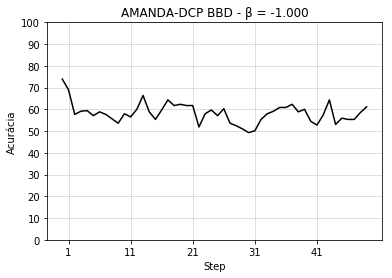

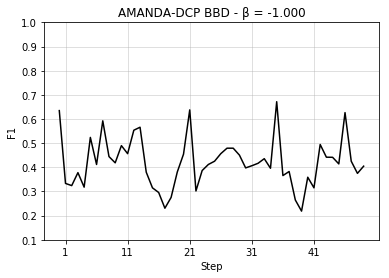

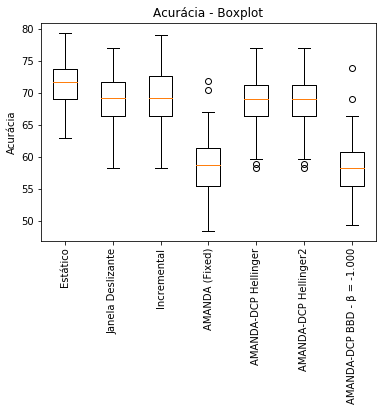

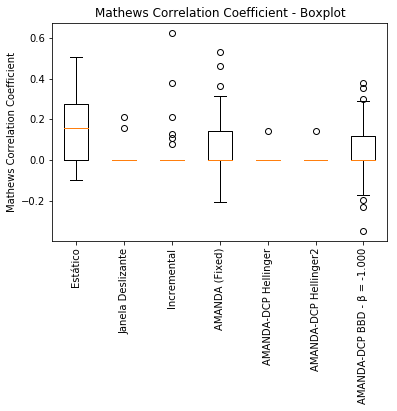

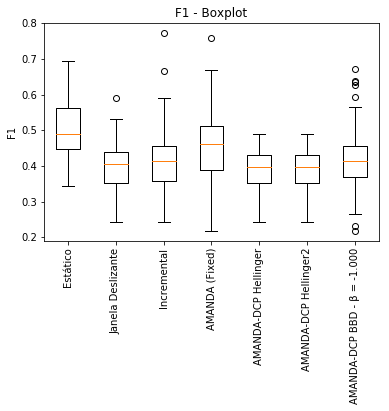

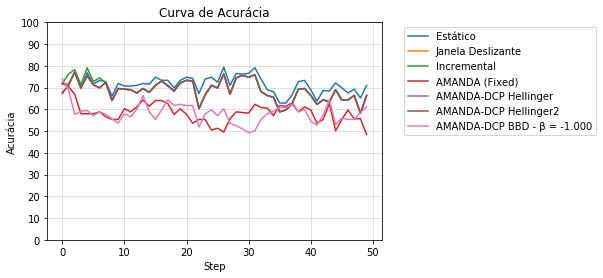

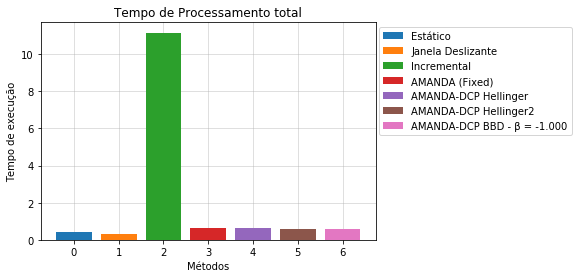

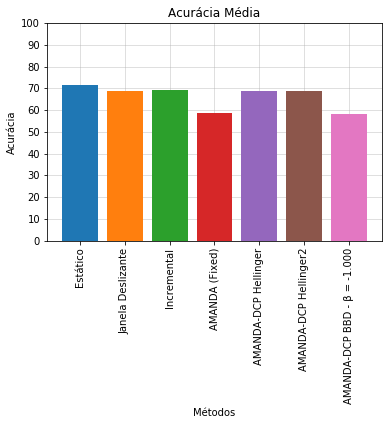

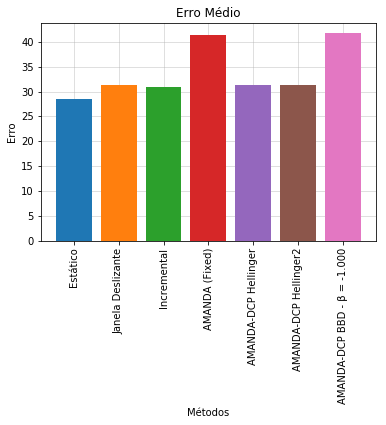

Pos 3 - Redução do Erro (Janela Deslizante):-3.882625836977839
Pos 2 - Redução do Erro (Incremental):-3.404432729785907
Pos 6 - Redução do Erro (AMANDA (Fixed)):-17.964279618452828
Pos 4 - Redução do Erro (AMANDA-DCP Hellinger):-4.012177275614373
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger2):-4.028406181534288
Pos 7 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-18.410574531250454


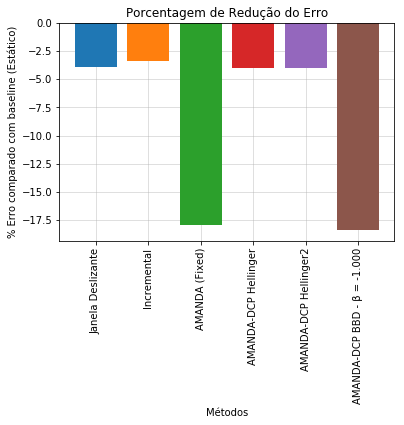

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])
import psutil
import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
'''
from methods import prequential_amanda_fixed
from methods import prequential_amanda_dynamic
from methods import prequential_static_classifier
from methods import prequential_deslizante_LN
from methods import prequential_incremental_LN
from methods import prequential_compose_gmm_version
'''


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 50
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    plot_animation = False
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadNOAADataset(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))
    
    # Static SSL
    experiments[0] = Experiment(static_classifier, 4, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 4, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 4, clfName=sslClassifier)
        
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 4, 0.6, "kde", sslClassifier)
    
     # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [5, 5, 5, 5]
    betas = [-1]
    bestK = [3]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
     # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'HDDDM')
    
    '''
    # memory usage
    #process = psutil.Process(os.getpid())
    
    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    #experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)
    
    #print("Memory:", process.memory_info().rss)

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 8)
    
    
    #prequential evaluation
    steps = 10
    dataValues, dataLabels = dataValues[:labeledData], dataLabels[:labeledData]
    labeledData = int(0.05*len(dataLabels))
    experiments[0] = Experiment(prequential_static_classifier, 8, clfName=sslClassifier)
    experiments[1] = Experiment(prequential_deslizante_LN, 8, clfName=sslClassifier)
    experiments[2] = Experiment(prequential_incremental_LN, 8, clfName=sslClassifier)
    experiments[3] = Experiment(prequential_amanda_fixed, 8, 0.7, "kde", sslClassifier)
    experiments[4] = Experiment(prequential_amanda_dynamic, 6, None, "kde", clfName=sslClassifier)
    experiments[5] = Experiment(prequential_compose_gmm_version, 8, 0.7)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'noaa', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    '''
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    
    
    

if __name__ == "__main__":
    main()